In [3]:
import sys
import os
sys.path.append('../../') # Add the root directory to sys.path

In [4]:
import torch
from torch import nn
from torch.optim.lr_scheduler import OneCycleLR
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from models.starcnet import StarcNet
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [5]:
data_dir = '../../data/Gaia DR3/train.parquet'

In [6]:
data = pd.read_parquet(data_dir)
data.head(5)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,2264606414026248192,5212.299316,4.4992,-1.2461,G,LM,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,17552.250000,3.4490,0.4213,B,M,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,5810.870605,3.9213,-0.5051,F,LM,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,14714.115234,3.8890,-0.2898,B,LM,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,7999.921387,3.1459,-2.2106,B,M,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [7]:
df = data.drop(columns = ['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,2264606414026248192,LM,"[2.6257292e-17, 2.8692712e-17, 3.0059525e-17, ..."
1,5242172756378861952,M,"[1.8050392e-14, 1.7178296e-14, 1.5548272e-14, ..."
2,2266498879696626944,LM,"[3.292663e-17, 3.039652e-17, 2.9301113e-17, 3...."
3,5337670598285980160,LM,"[1.2267033e-15, 1.2095414e-15, 1.155193e-15, 1..."
4,4063146749806089600,M,"[2.0976588e-14, 2.2193906e-14, 2.1269509e-14, ..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14101 entries, 0 to 14100
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source_id  14101 non-null  int64 
 1   Cat        14101 non-null  object
 2   flux       14101 non-null  object
dtypes: int64(1), object(2)
memory usage: 330.6+ KB


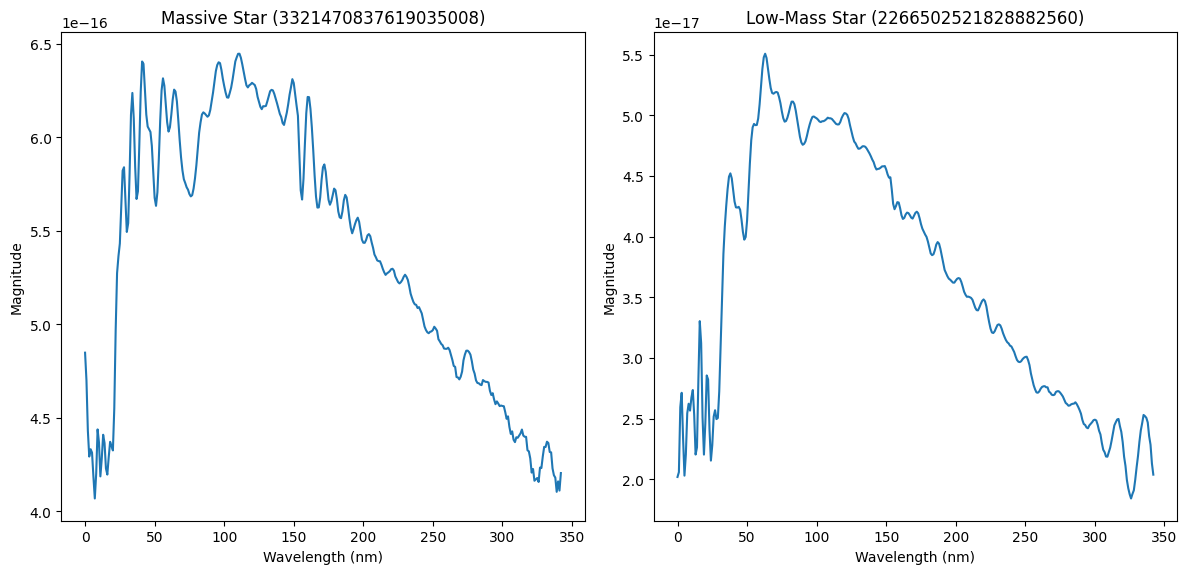

In [9]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(12, 6))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [10]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 14101
Number of bins in each spectra: 343
In the dataset, we have 8820 spectra for low mass stars and 5281 spectra for high mass stars.


In [11]:
X = np.vstack(df['flux'])
y = np.vstack(df['Cat'])

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(X/np.linalg.norm(X,keepdims=True)).float()

In [12]:
def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [37]:
def fit_model(model, x_train, y_train, x_val, y_val, prt_steps = 1, verbose=True):
    
    # initialize weights
    model.apply(init_weights)

    # hyperparameters
    epochs = 200
    learning_rate = 1e-4
    batch_size = 32
    device = 'cuda'
    
    # model components
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # move everything to gpu
    model.to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    x_val = x_val.to(device)
    y_val = y_val.to(device)

    # metrics
    training_losses, validation_losses = [], []
    accuracy = []
    
    # lr cycling
    max_lr = 1e-3
    steps_per_epoch = len(x_train) // batch_size
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=steps_per_epoch, epochs=epochs)

    batch_start = torch.arange(0, len(x_train), batch_size)

    for epoch in tqdm(range(epochs), desc='Epochs', dynamic_ncols=True):
        
        model.train()
        running_loss = 0

        for start in batch_start:

            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            output = model(x_batch.unsqueeze(1))
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * x_batch.size(0)

        train_loss = running_loss / len(x_train)
        training_losses.append(train_loss)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}', end='\r')


        model.eval()
        preds, labels = [], []

        with torch.no_grad():
            
            output = model(x_val.unsqueeze(1))
            loss = criterion(output, y_val)

            probs = torch.sigmoid(output)
            pred = torch.round(probs).cpu().numpy().astype(float)  # pred: [batch_size]
            
            preds.extend(pred)
            labels.extend(y_val.cpu().numpy())
            
            val_loss = loss.item()
        
        epoch_acc = accuracy_score(labels, preds)
        validation_losses.append(val_loss)
        accuracy.append(epoch_acc)
        if verbose and (epoch+1) % prt_steps == 0:
            print(f'Train loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {epoch_acc:.4f}', end='\r')
        
            
    return training_losses, validation_losses, accuracy

In [38]:
kfold = StratifiedKFold(n_splits=5)

training_losses, validation_losses, accuracy_scores = [], [], []

model = CNN()
print(model)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    
    print(f"\nFitting fold {fold+1}")

    tr_loss, val_loss, acc = fit_model(model, X[train_idx], y[train_idx], X[val_idx], y[val_idx], prt_steps=1, verbose=True)
    training_losses.append(tr_loss)
    validation_losses.append(val_loss)
    accuracy_scores.append(acc)

training_losses = np.mean(training_losses, axis=0)
validation_losses = np.mean(validation_losses, axis=0)
accuracy_scores = np.mean(accuracy_scores, axis=0)

CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2720, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Fitting fold 1


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.3278, Val Loss: 0.3068, Accuracy: 0.8827
Fitting fold 2


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.2980, Val Loss: 0.2629, Accuracy: 0.8936
Fitting fold 3


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.2915, Val Loss: 0.2643, Accuracy: 0.8876
Fitting fold 4


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Train loss: 0.3014, Val Loss: 0.3101, Accuracy: 0.8652
Fitting fold 5


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

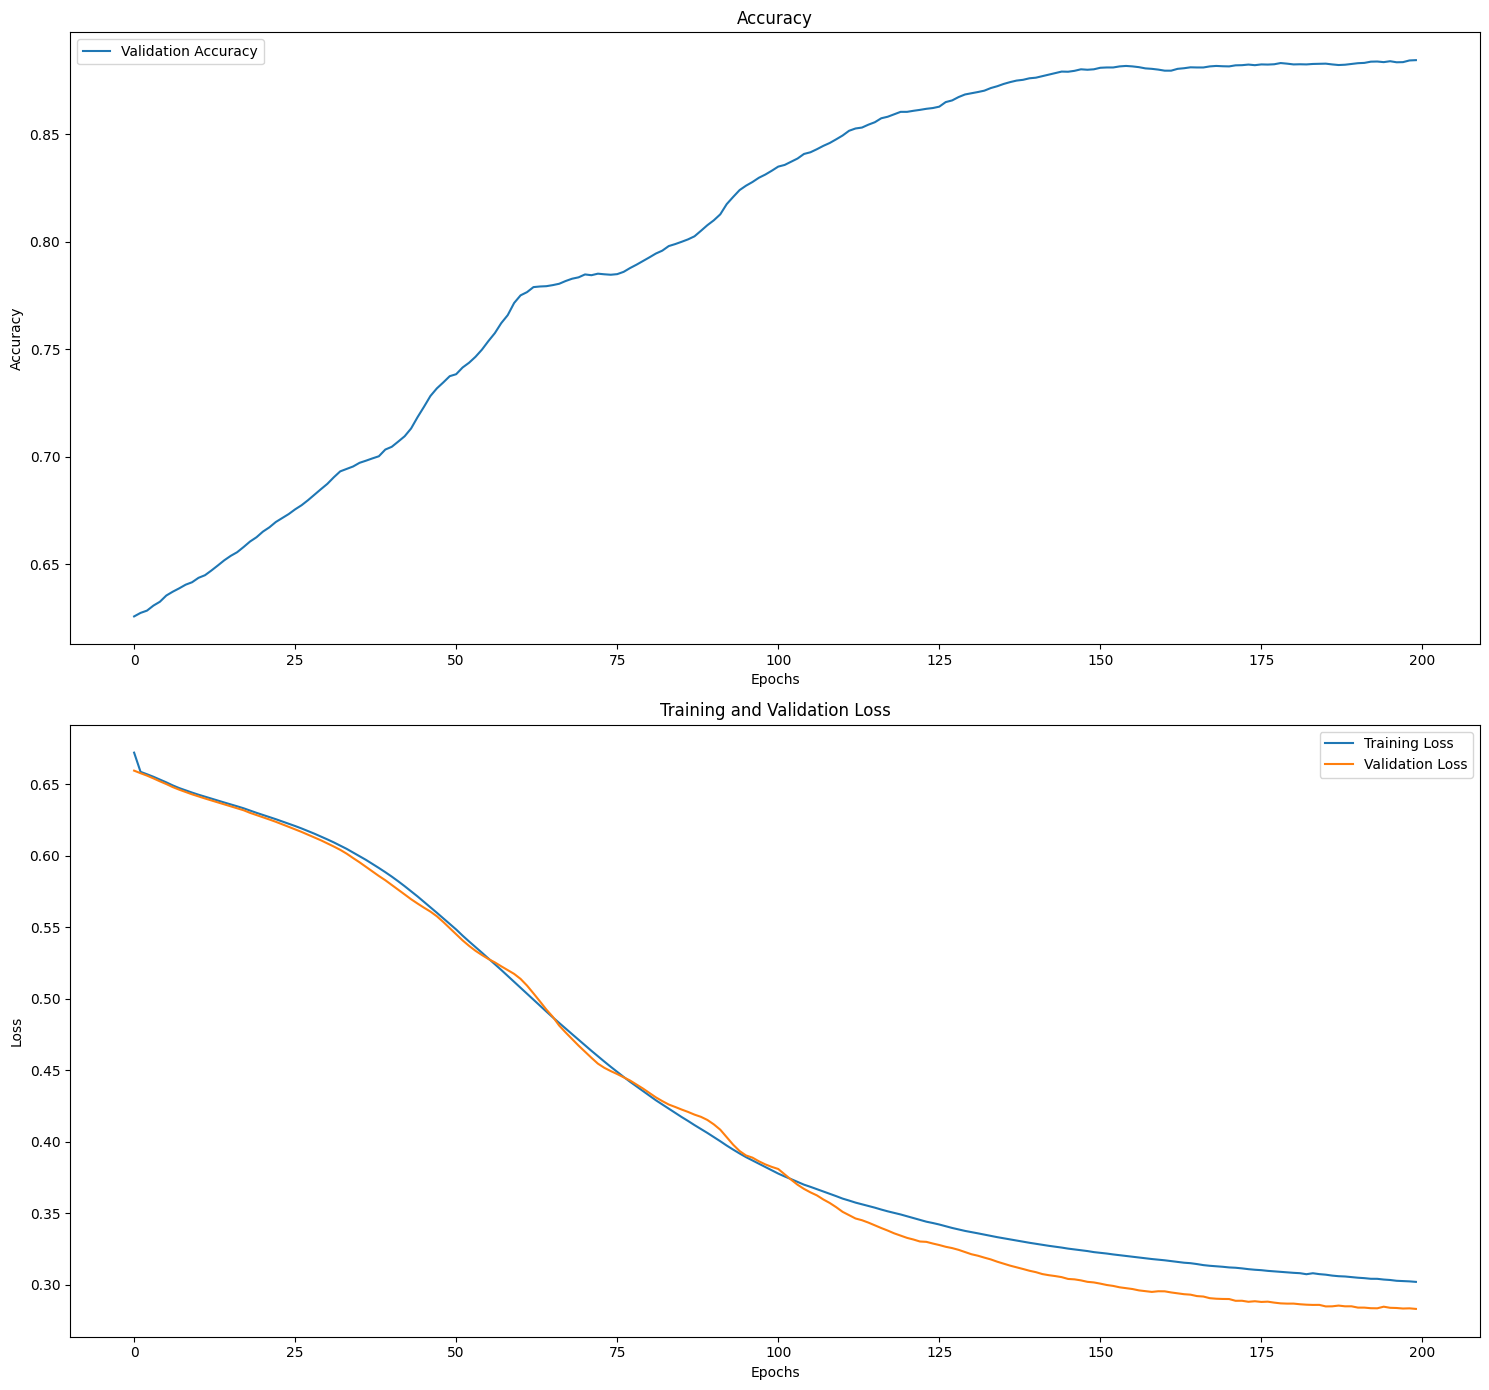

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 14))
    
ax1.plot(accuracy_scores, label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(training_losses, label='Training Loss')
ax2.plot(validation_losses, label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()